In [11]:
# ============================================
# Importación de librerías
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pygimli as pg
from pygimli.physics.ves import VESManager

import scipy.stats as stats
from scipy.stats import (
    norm, lognorm, gamma, expon,
    weibull_min, beta, genextreme, loggamma
)

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, pairwise_distances
from sklearn.preprocessing import StandardScaler

import joblib
from typing import Dict, Any, List, Tuple, Optional


In [12]:
# ============================================
# Definiciones de funciones
# ============================================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carga el archivo CSV con los modelos caracterizados.

    Args:
        filepath (str): Ruta al archivo CSV.

    Returns:
        pd.DataFrame: DataFrame con los datos cargados.
    """
    return pd.read_csv(filepath)

In [13]:
def compute_statistics(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Calcula estadísticas descriptivas por sitio.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (List[str]): Columnas a analizar.

    Returns:
        pd.DataFrame: DataFrame con estadísticas agregadas.
    """
    grouped = df.groupby('Sitio')
    stats_df = grouped[cols].agg(['mean', 'std', 'median', 'min', 'max'])
    return stats_df


In [14]:
def compute_std_sum(stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula la suma de desviaciones estándar de espesores por sitio.

    Args:
        stats_df (pd.DataFrame): DataFrame de estadísticas.

    Returns:
        pd.DataFrame: DataFrame con suma de desviaciones estándar por sitio.
    """
    suma_std = (
        stats_df.loc[:, [('Espesor_1', 'std'), ('Espesor_2', 'std'), ('Espesor_3', 'std')]]
        .sum(axis=1)
        .to_dict()
    )
    df_suma = pd.DataFrame.from_dict(suma_std, orient='index', columns=['suma_std'])
    df_suma.reset_index(inplace=True)
    df_suma.rename(columns={'index': 'Sitio'}, inplace=True)
    return df_suma


In [15]:
def compute_site_correlations(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Calcula la correlación de Pearson entre todos los sitios
    en función de las variables seleccionadas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (List[str]): Columnas a considerar.

    Returns:
        pd.DataFrame: Matriz de correlación entre sitios.
    """
    # Calcular promedio por sitio
    site_means = df.groupby("Sitio")[cols].mean()
    corr_matrix = site_means.T.corr(method="pearson")
    return corr_matrix


In [16]:
def plot_correlation_matrix(corr_matrix: pd.DataFrame) -> None:
    """
    Grafica la matriz de correlación entre sitios.

    Args:
        corr_matrix (pd.DataFrame): Matriz de correlación.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de Correlación entre Sitios")
    plt.tight_layout()
    plt.show()

In [17]:
def plot_histograms(df: pd.DataFrame, cols: list) -> None:
    """
    Genera histogramas con densidad para un conjunto de columnas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Lista de columnas numéricas a graficar.
    """
    df[cols].hist(figsize=(14, 10), bins=20, edgecolor="black")
    plt.suptitle("Distribuciones univariadas de espesores y resistividades", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_boxplots_by_site(df: pd.DataFrame, cols: list) -> None:
    """
    Genera boxplots por sitio para cada variable.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas a graficar.
    """
    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))

    for i, col in enumerate(cols):
        sns.boxplot(x="Sitio", y=col, data=df, ax=axes[i])
        axes[i].set_title(f"Distribución de {col} por Sitio")

    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame, cols: list) -> None:
    """
    Grafica un heatmap de correlación entre columnas numéricas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas numéricas a correlacionar.
    """
    corr = df[cols].corr(method="pearson")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación entre variables")
    plt.tight_layout()
    plt.show()


def plot_pairwise(df: pd.DataFrame, cols: list) -> None:
    """
    Genera un pairplot de dispersión cruzada entre variables.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas numéricas a considerar.
    """
    sns.pairplot(df[cols], diag_kind="kde")
    plt.suptitle("Relaciones bivariadas entre espesores y resistividades", y=1.02)
    plt.show()


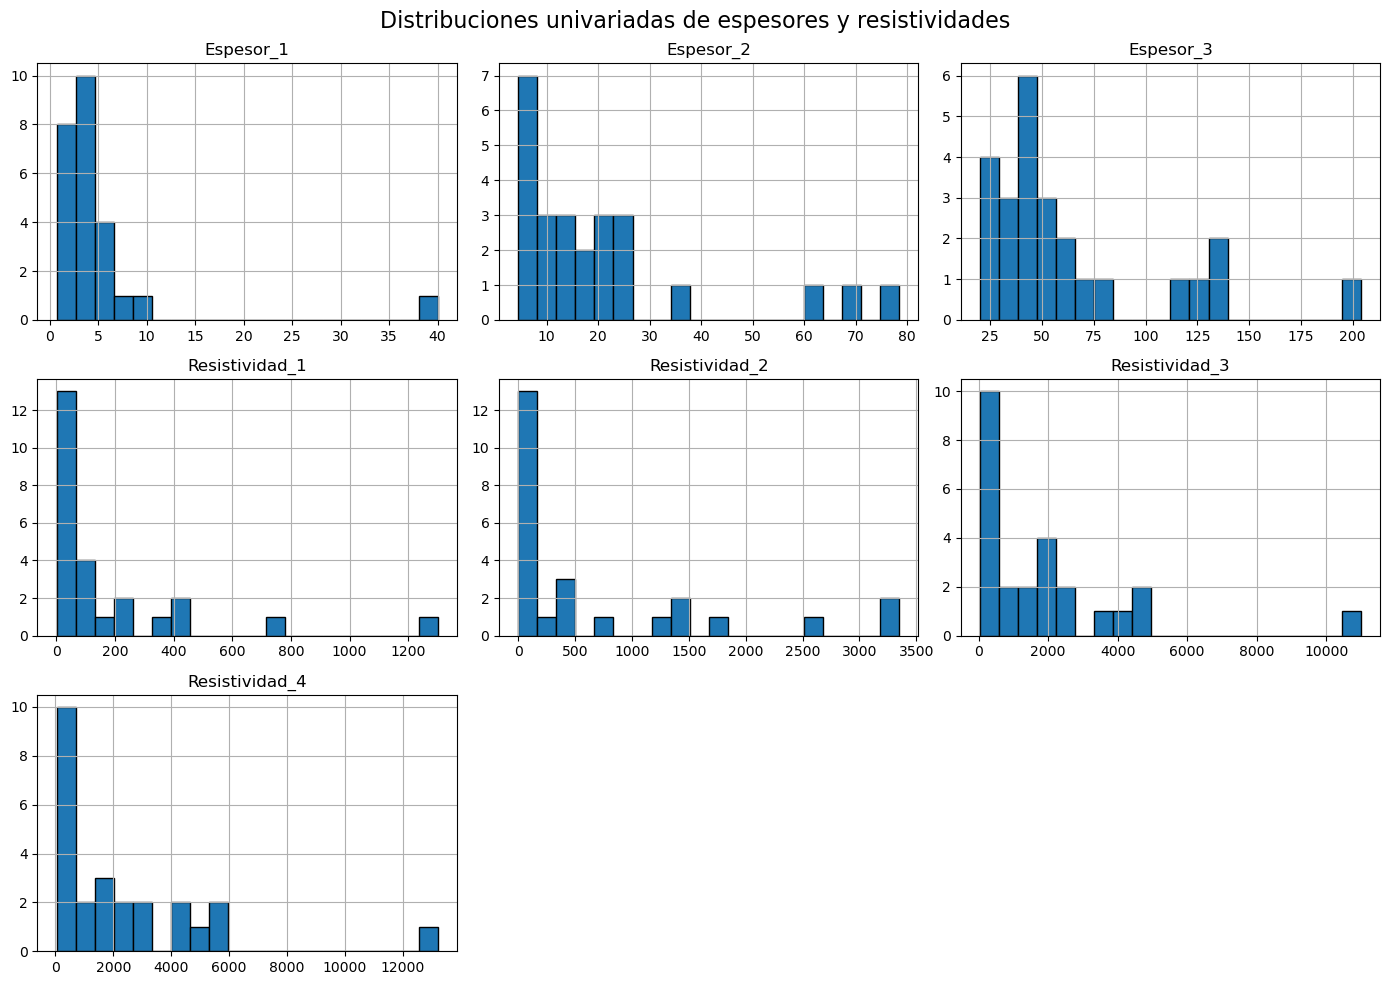

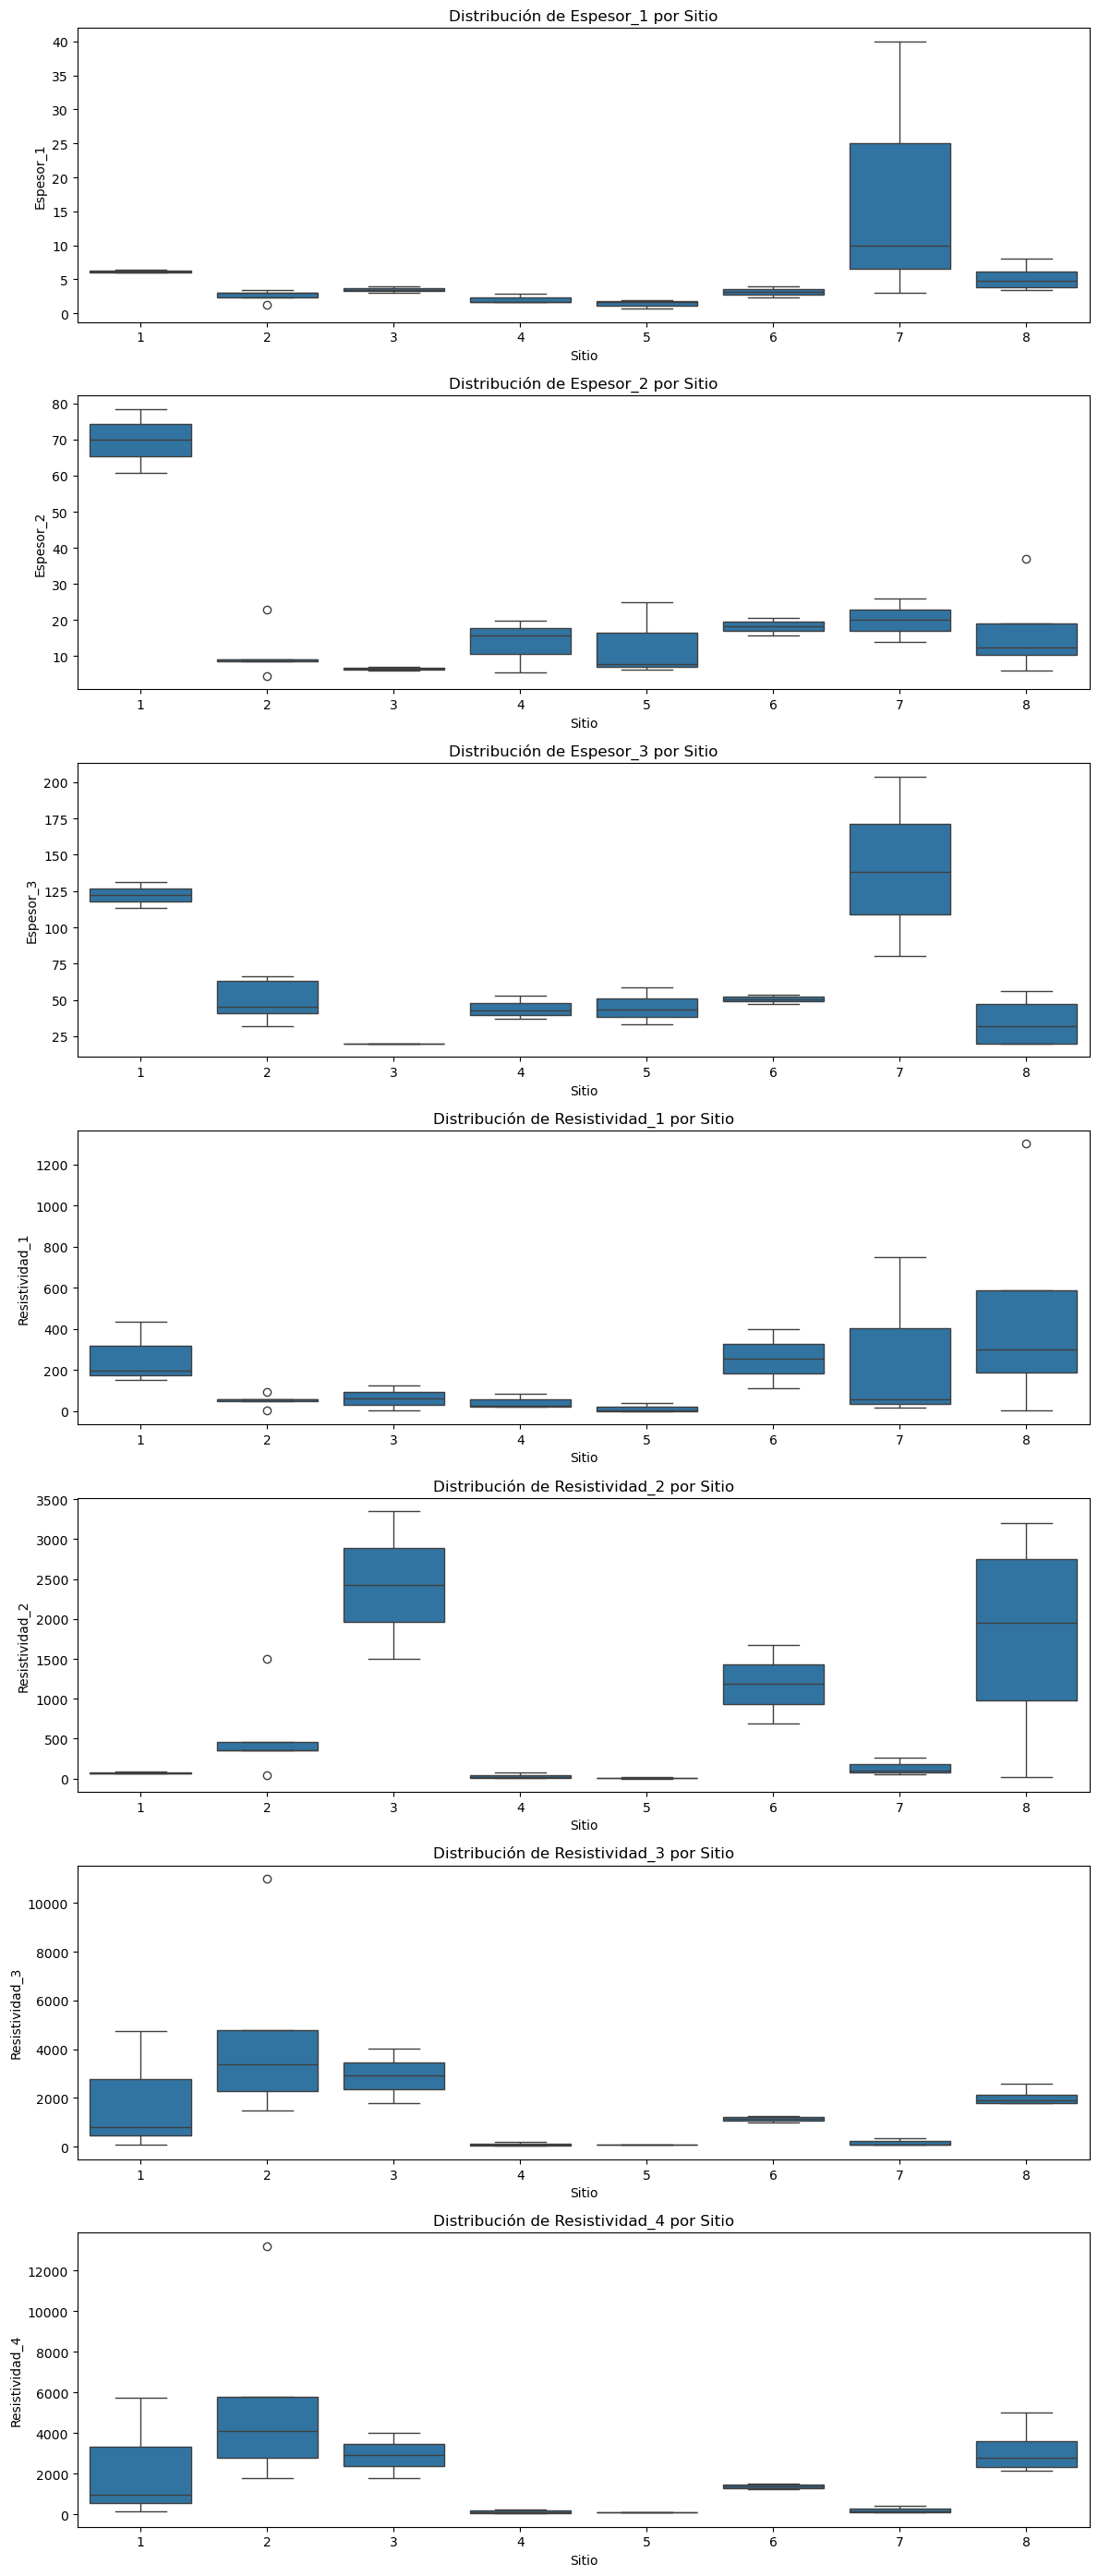

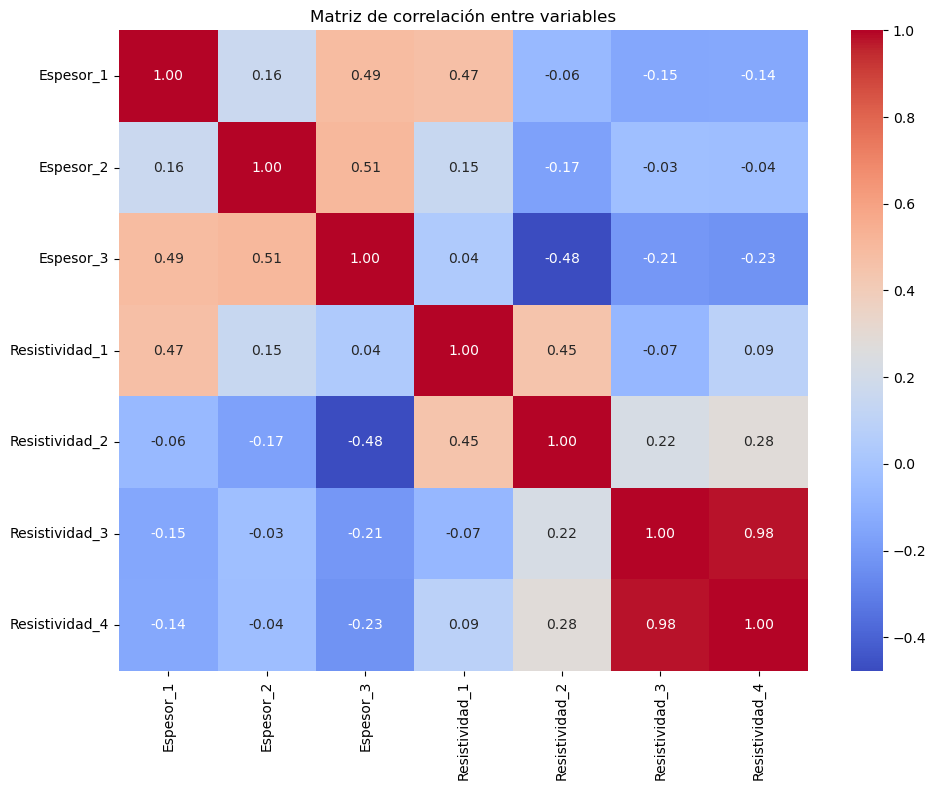

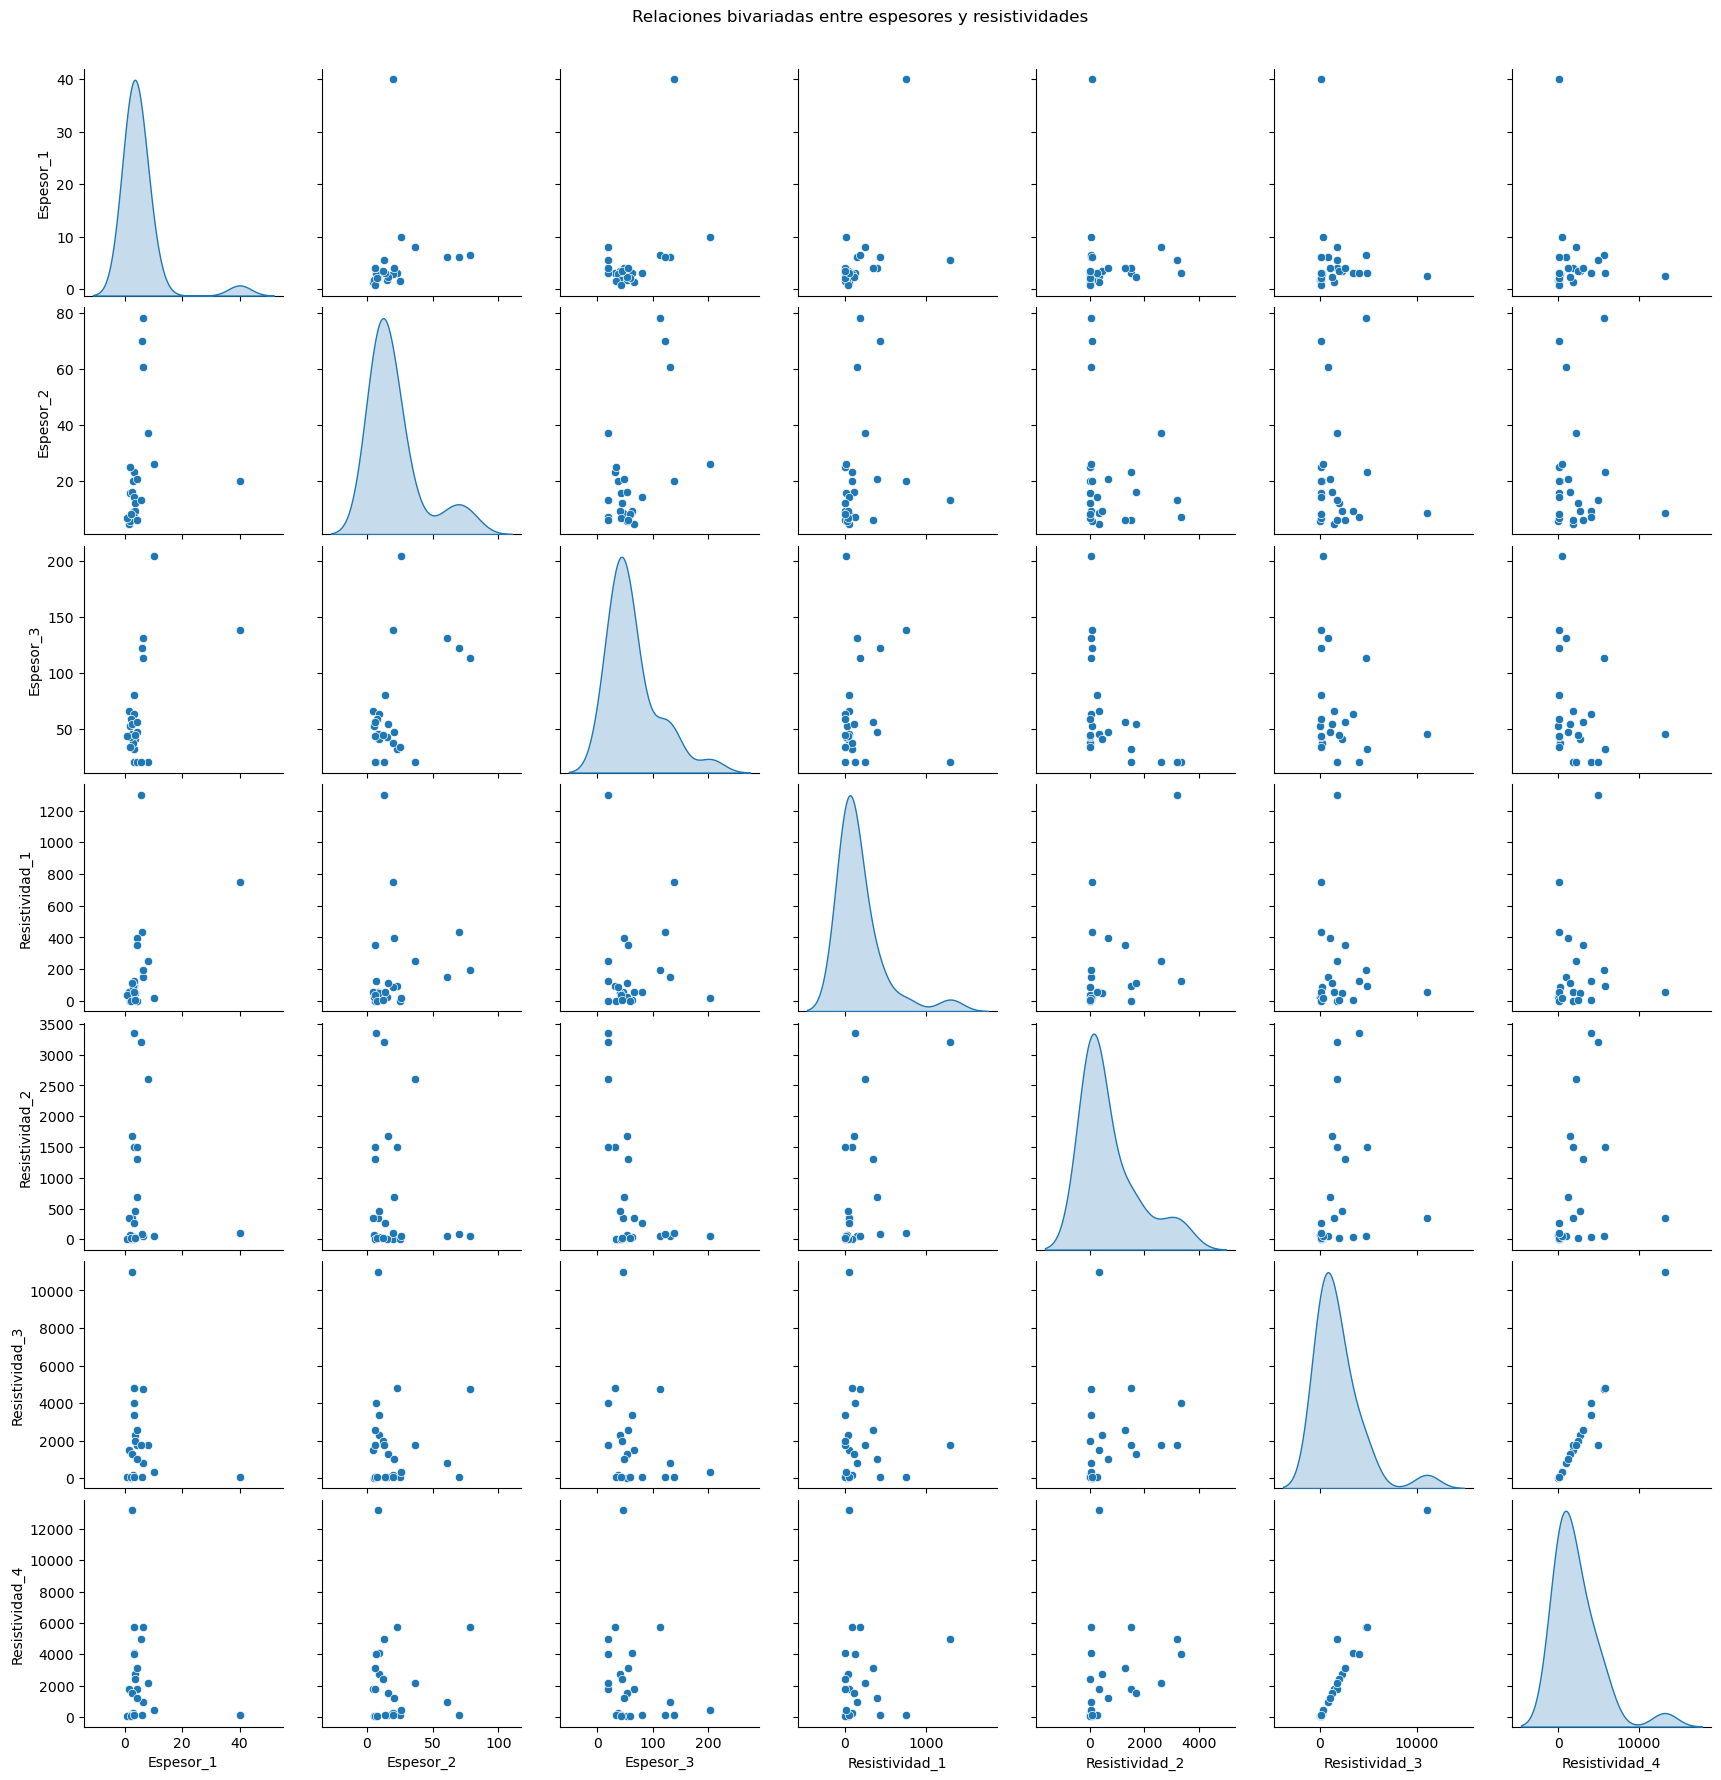

In [18]:
if __name__ == "__main__":
    # 1. Cargar datos
    df = load_data("DATOS/Modelos-caracterizados-completo.csv")

    columnas = [
        "Espesor_1", "Espesor_2", "Espesor_3",
        "Resistividad_1", "Resistividad_2", 
        "Resistividad_3", "Resistividad_4"
    ]

    # Estadísticos básicos
    stats_df = compute_statistics(df, columnas)
    stats_df.to_csv("stats.csv")

    # 2. Histogramas
    plot_histograms(df, columnas)

    # 3. Boxplots por sitio
    plot_boxplots_by_site(df, columnas)

    # 4. Correlación (heatmap)
    plot_correlation_heatmap(df, columnas)

    # 5. Dispersión cruzada
    plot_pairwise(df, columnas)

Archivo 'stats.csv' generado.
Archivo 'suma_std_por_sitio.csv' generado.
Archivo 'correlacion_sitios.csv' generado.


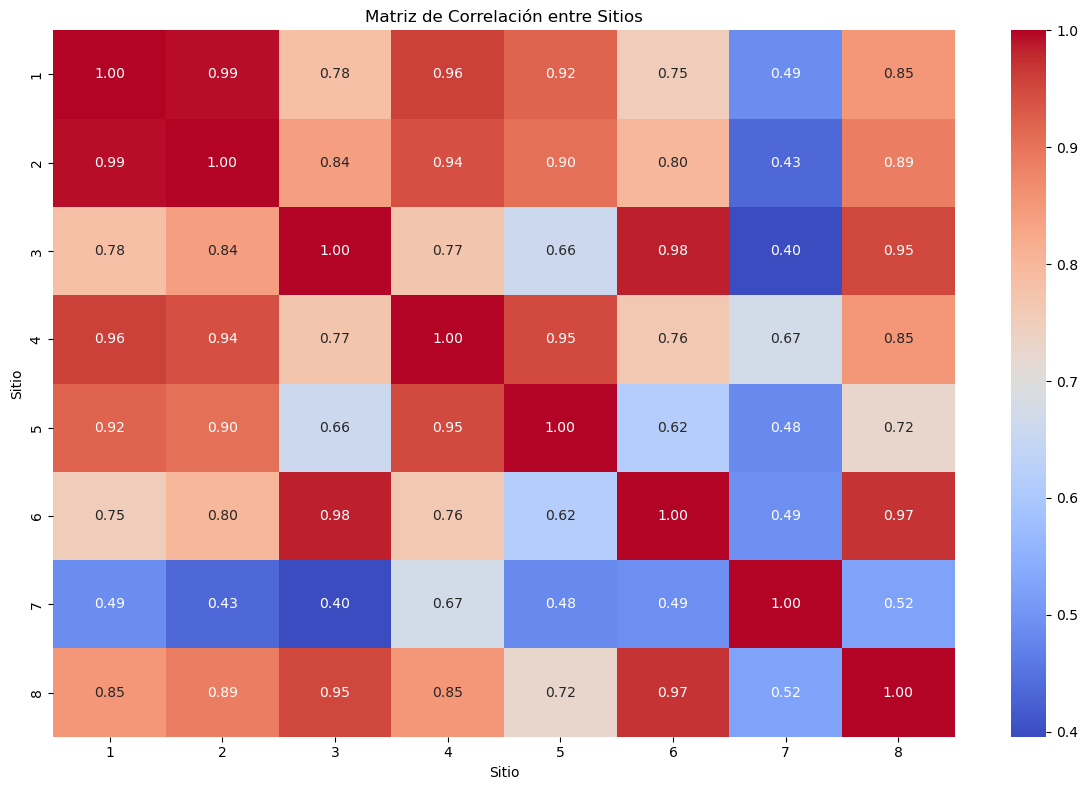

In [19]:
# ============================================
# Ejecución principal
# ============================================

if __name__ == "__main__":
    # 1. Cargar datos
    df = load_data("DATOS/Modelos-caracterizados-completo.csv")

    # 2. Definir columnas de interés
    columnas = [
        'Espesor_1', 'Espesor_2', 'Espesor_3',
        'Resistividad_1', 'Resistividad_2',
        'Resistividad_3', 'Resistividad_4'
    ]

    # 3. Estadísticos descriptivos por sitio
    stats_df = compute_statistics(df, columnas)
    stats_df.to_csv("DATOS/stats.csv")
    print("Archivo 'stats.csv' generado.")

    # 4. Suma de desviaciones estándar por sitio
    df_suma_std = compute_std_sum(stats_df)
    df_suma_std.to_csv("DATOS/suma_std_por_sitio.csv", index=False)
    print("Archivo 'suma_std_por_sitio.csv' generado.")

    # 5. Correlación general entre todos los sitios
    corr_matrix = compute_site_correlations(df, columnas)
    corr_matrix.to_csv("DATOS/correlacion_sitios.csv")
    print("Archivo 'correlacion_sitios.csv' generado.")

    # 6. Visualización de la matriz de correlación
    plot_correlation_matrix(corr_matrix)
